In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Watermass transformation and overturning in ECCO
21/05/21
- Look at the balance of terms in wmt within distinct watermasses

In [9]:
import xarray as xr
import so_decadal_variability as so
import matplotlib.pyplot as plt
import numpy as np
import utils.operations as op

In [10]:
rootdir = '../../data/processed/ECCO/'
filename_all = 'binned_vol_budget_month_dGamman_0.02_BF_G.nc'
filename_bowl = 'binned_vol_budget_month_dGamman_0.02_bowl_p2_BF_G.nc'
ds_all = xr.open_dataset(rootdir+filename_all).isel(gamma_n=slice(1,-1))
ds_bowl = xr.open_dataset(rootdir+filename_bowl).isel(gamma_n=slice(1,-1))

In [11]:
# Only retain non-zero values
# (This relies on the fact that nowhere else is exactly zero)
ds_all = ds_all.where(ds_all['bin_ADV']!=0,drop=True)
ds_bowl = ds_bowl.where(ds_bowl['bin_ADV']!=0,drop=True)

### Time-mean distribution

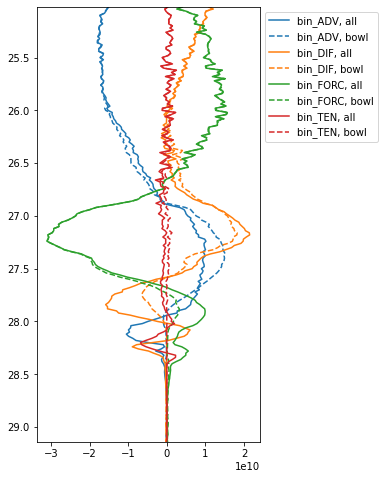

In [12]:
terms = ['bin_ADV','bin_DIF','bin_FORC','bin_TEN']
colors = {'bin_ADV':'tab:blue','bin_DIF':'tab:orange','bin_FORC':'tab:green','bin_TEN':'tab:red'}
fig,ax = plt.subplots(figsize=(4,8))
for term in terms:
    ax.plot(ds_all[term].mean('time'),ds_all['gamma_n'],
            label=term+', all',color=colors[term])
    ax.plot(ds_bowl[term].mean('time'),ds_bowl['gamma_n'],
            label=term+', bowl',color=colors[term],linestyle='--')
ax.invert_yaxis()
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

#### Getting watermass boundaries
- WM boundaries are selected based on overturning at the northern boundary  
- Look for maxima and zero crossing to define watermasses  
- Check first that a smoothed profile gives a reasonable picture

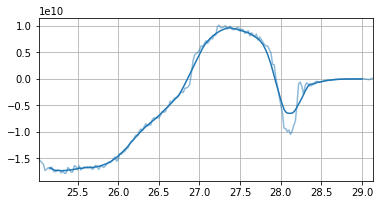

In [13]:
X = ds_all['bin_ADV'].mean('time')
Xsmooth = X.rolling({'gamma_n':15},center=True).mean()
fig,ax=plt.subplots(figsize=(6,3))
ax.plot(X['gamma_n'],X,alpha=0.5)
ax.plot(X['gamma_n'],Xsmooth,color='tab:blue')
ax.grid()
ax.autoscale(enable=True, axis='x', tight=True)

In [70]:
# Find the crossing points of the time-mean advection
c = op.crossing(Xsmooth,'gamma_n')
ex = op.extrema(Xsmooth,'gamma_n',order=10)
# List and sort them
bounds = np.sort(np.concatenate((c.values, ex['min'].values, ex['max'].values)))

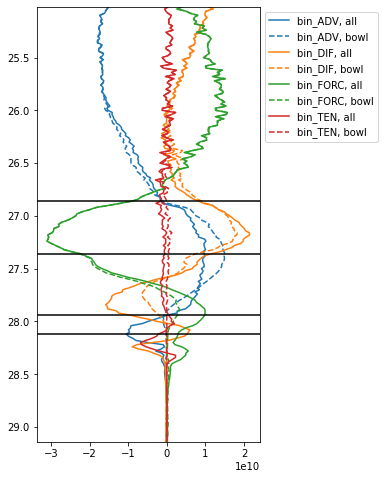

In [71]:
# Replot, with watermasses
fig,ax = plt.subplots(figsize=(4,8))
for term in terms:
    ax.plot(ds_all[term].mean('time'),ds_all['gamma_n'],
            label=term+', all',color=colors[term])
    ax.plot(ds_bowl[term].mean('time'),ds_bowl['gamma_n'],
            label=term+', bowl',color=colors[term],linestyle='--')
ax.invert_yaxis()
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
xlim = ax.get_xlim()
for b in bounds:
    ax.plot(xlim,(b, b),'k')
ax.autoscale(enable=True, axis='x', tight=True)

### Plot formation, together with watermass boundaries

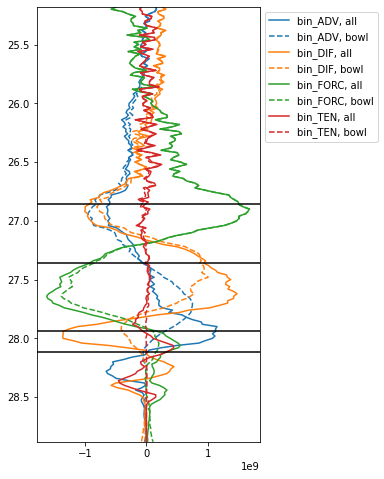

In [90]:
# Calculate formation
formation_all = -1*ds_all.diff('gamma_n')
formation_bowl = -1*ds_bowl.diff('gamma_n')
# Plot, smoothed, with watermasses
fig,ax = plt.subplots(figsize=(4,8))
for term in terms:
    ax.plot(formation_all[term].mean('time').rolling({'gamma_n':15},center=True).mean(),formation_all['gamma_n'],
            label=term+', all',color=colors[term])
    ax.plot(formation_bowl[term].mean('time').rolling({'gamma_n':15},center=True).mean(),formation_bowl['gamma_n'],
            label=term+', bowl',color=colors[term],linestyle='--')
ax.invert_yaxis()
ax.autoscale(enable=True, axis='y', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
xlim = ax.get_xlim()
for b in bounds:
    ax.plot(xlim,(b, b),'k')
ax.autoscale(enable=True, axis='x', tight=True)

### Integrate formation within watermasses

In [194]:
bins = np.concatenate(([ds_all['gamma_n'].min('gamma_n')],bounds,[ds_all['gamma_n'].max('gamma_n')]))
bins_c = 0.5*(bins[1:]+bins[:-1])
bins_w = np.diff(bins)
wmf_all = formation_all.groupby_bins('gamma_n',bins,labels=bins_c).sum()
wmf_bowl = formation_bowl.groupby_bins('gamma_n',bins,labels=bins_c).sum()

<BarContainer object of 5 artists>

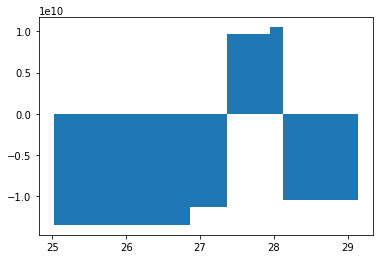

In [195]:
# Plot the overturning
plt.bar(wmf_all['gamma_n_bins'],wmf_all['bin_ADV'].mean('time'),width=bins_w)

### Plot time series of balance for each watermass

In [196]:
# Add together surface forcing and diffusion within bowl
wmf_all['bin_FORCDIF'] = wmf_all['bin_FORC']+wmf_all['bin_DIF']
wmf_bowl['bin_FORCDIF'] = wmf_bowl['bin_FORC']+wmf_bowl['bin_DIF']
colors['bin_FORCDIF'] = 'tab:purple'
termsnew = terms.copy()
termsnew.append('bin_FORCDIF')

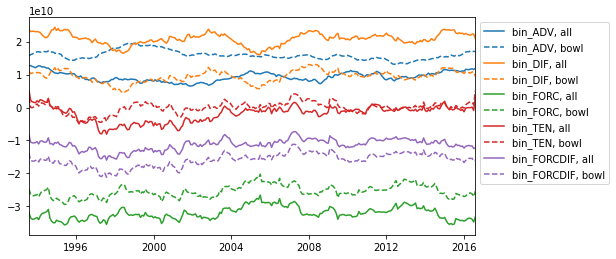

In [197]:
# Plot, smoothed
g = bins_c[2]
fig,ax = plt.subplots(figsize=(8,4))
for term in termsnew:
    ax.plot(wmf_all['time'],wmf_all[term].sel({'gamma_n_bins':g},method='nearest').rolling({'time':36},center=True).mean(),
            label=term+', all',color=colors[term])
    ax.plot(wmf_bowl['time'],wmf_bowl[term].sel({'gamma_n_bins':g},method='nearest').rolling({'time':36},center=True).mean(),
            label=term+', bowl',color=colors[term],linestyle='--')
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

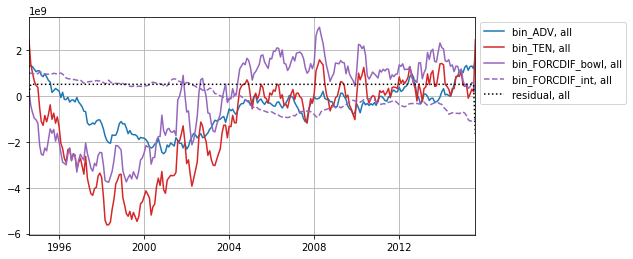

In [217]:
# Plot full advection, full tendency, bowl wmt, and subsurface wmt
termsnew = ['bin_ADV','bin_TEN','bin_FORCDIF_bowl','bin_FORCDIF_int'];
ds = xr.Dataset()
ds['bin_ADV'] = wmf_all['bin_ADV']
ds['bin_TEN'] = wmf_all['bin_TEN']
ds['bin_FORCDIF_bowl'] = wmf_bowl['bin_FORCDIF']
ds['bin_FORCDIF_int'] = wmf_all['bin_FORCDIF'] - wmf_bowl['bin_FORCDIF']
ds['residual'] = -1*ds['bin_TEN'] + ds['bin_ADV'] + ds['bin_FORCDIF_bowl'] + ds['bin_FORCDIF_int']
colorsnew = {'bin_ADV':'tab:blue','bin_TEN':'tab:red','bin_FORCDIF_bowl':'tab:purple','bin_FORCDIF_int':'tab:purple','residual':'black'}
lines = {'bin_ADV':'-','bin_TEN':'-','bin_FORCDIF_bowl':'-','bin_FORCDIF_int':'--','residual':':'}

g = bins_c[2]
fig,ax = plt.subplots(figsize=(8,4))
residual = xr.zeros_like(ds['bin_ADV'].sel({'gamma_n_bins':g},method='nearest'))
for term in ds.data_vars:
    val = ds[term].sel({'gamma_n_bins':g},method='nearest')
    anom = val - val.mean('time')
    smoothed = anom.rolling({'time':60},center=True).mean()
    ax.plot(ds['time'],smoothed,
            label=term+', all',color=colorsnew[term],linestyle=lines[term])
ax.autoscale(enable=True, axis='x', tight=True)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid()